# 大通胀时期的投资策略研究

本文主要研究历次高通胀时期，联邦利率、CPI和各类资产价格之间的相关性，以期望对当前的资产配置策略有所启发。
US CPI Data Source:
https://data.bls.gov/timeseries/CUUR0000SA0?years_option=all_years


US SP500 Data Source: yahoo finance

In [1]:
#prepare data
import yfinance as yf
import pandas as pd
df_sp500=yf.download('^GSPC')['Adj Close']
df_cpi=pd.read_csv('../data/share/cpius.csv')
df_gdp=pd.read_csv('../data/share/GDPUS.csv')
#df_rate=pd.read_csv('../data/share/Interest rate US Upper Limit.csv')
df_rate=yf.download('^TNX')['Adj Close']
df_gold=yf.download('IAU')
df_fedrate=pd.read_csv('../data/share/fedrate.csv')
df_fedrate=df_fedrate.set_index(pd.to_datetime(df_fedrate.date,format='%d/%m/%Y'))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
df_fedrate.columns=['Date','Rate']

In [3]:
#process data
df=pd.DataFrame(index=pd.date_range(start='1950-01-01',end='2022-01-01',freq='1M'))
df['CPI']=df_cpi.set_index(pd.to_datetime(df_cpi.DATE,format='%d/%m/%Y')+pd.offsets.MonthEnd(0))['CPIAUCSL']
df['SP500']=df_sp500.resample('1M').last()
df['USGDP']=df_gdp.set_index(pd.to_datetime(df_gdp.DATE,format='%d/%m/%Y')+pd.offsets.MonthEnd(0))['GDPC1']
df['10YYield']=df_rate.resample('1M').last()/100
df['CPIYOY']=df['CPI']/df['CPI'].shift(12)-1
df['SP500YOY']=df['SP500']/df['SP500'].shift(12)-1
df['USGDPYOY']=df['USGDP']/df['USGDP'].shift(12)-1
df['CPIShifted']=df['CPI'].shift(1)
df['CPIShiftedYOY']=df['CPIShifted']/df['CPIShifted'].shift(12)-1
df['USGDPShifted']=df['USGDP'].shift(1)
df['USGDPShiftedYOY']=df['USGDPShifted']/df['USGDPShifted'].shift(12)-1
df['Rate']=df_fedrate.resample('1M').last()['Rate']/100

In [4]:
df.to_csv('../data/share/marcodata.csv')

In [5]:
#data for reporting

dfq=df[['CPIShiftedYOY','SP500','10YYield','USGDPShifted']].dropna()
dfm=df[['CPIShiftedYOY','SP500','Rate']].dropna()
dfq.columns=['CPI','SP500','Rate','GDP']
dfm.columns=['CPI','SP500','Rate']
dfm['SP500 MoM']=dfm['SP500']/dfm['SP500'].shift(1)-1
dfm['SP500 Growth']=dfm['SP500']/dfm['SP500'][0]-1
dfq['SP500 QoQ']=dfq['SP500']/dfq['SP500'].shift(1)-1
dfq['GDP YOY']=dfq['GDP']/dfq['GDP'].shift(4)-1
dfq=dfq.dropna()
dfm=dfm.dropna()


In [47]:
dfq.index

DatetimeIndex(['1963-02-28', '1963-05-31', '1963-08-31', '1963-11-30',
               '1964-02-29', '1964-05-31', '1964-08-31', '1964-11-30',
               '1965-02-28', '1965-05-31',
               ...
               '2019-08-31', '2019-11-30', '2020-02-29', '2020-05-31',
               '2020-08-31', '2020-11-30', '2021-02-28', '2021-05-31',
               '2021-08-31', '2021-11-30'],
              dtype='datetime64[ns]', length=236, freq='3M')

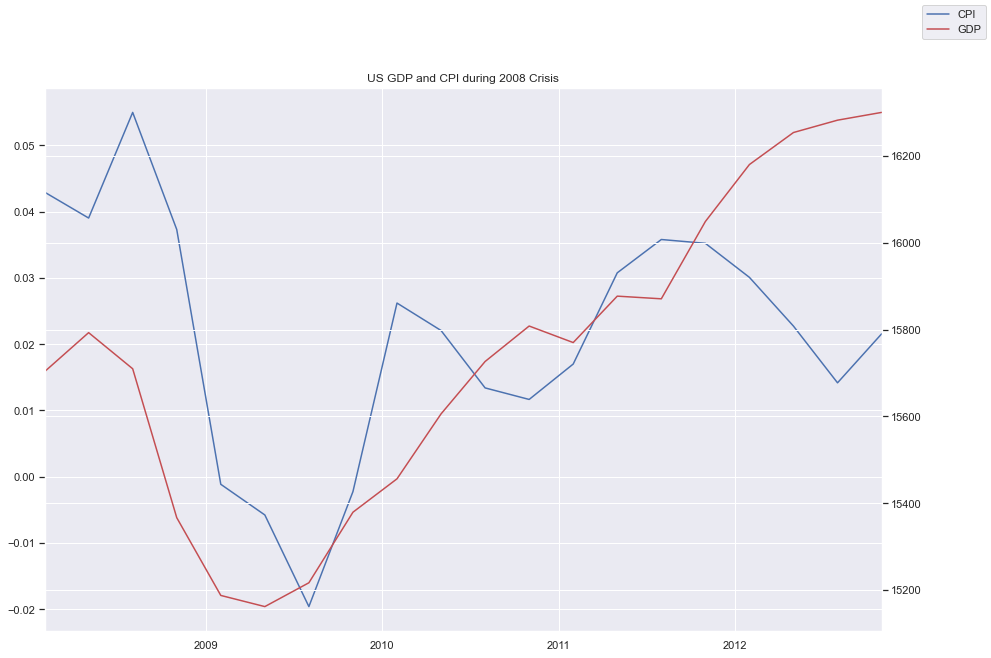

In [58]:
data=dfq[180:200]
ax = data.plot(y="CPI", legend=False)
ax2 = ax.twinx()
data.plot(y="GDP", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.title('US GDP and CPI during 2008 Crisis')
plt.show()


Text(0.5, 1.0, 'CPI/Rate/SP500 Monthly Data')

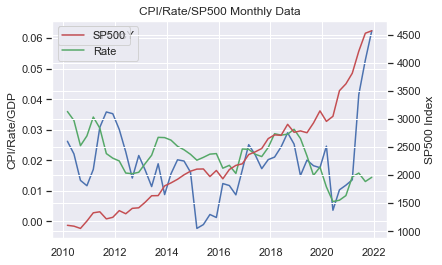

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()
fig=plt.figure()
dfm=dfq.loc[dt.date(2010,1,1):dt.date(2023,1,1),]

plt.rcParams['figure.figsize'] = (15, 10)
ax1=fig.add_subplot(111)
ax2=ax1.twinx()
ln1=ax1.plot(dfm.index,dfm['CPI'],color='b',label='CPI YoY')
ln2=ax1.plot(dfm.index,dfm['Rate'],color='g',label='Rate')
#ln4=ax1.plot(dfm.index,dfm['GDP YOY'],color='y',label='GDP YoY')

ln3=ax2.plot(dfm.index,dfm['SP500'],color='r',label='SP500')
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.set_ylabel('CPI/Rate/GDP')
ax2.set_ylabel('SP500 Index')
plt.title('CPI/Rate/SP500 Monthly Data')
# plt.ylabel('CPI & Rate')
# ln1=sns.lineplot(data=dfm['CPI'],color='g',label='CPI')
# ln2=sns.lineplot(data=dfm['Rate'],color='b',label='Rate')

# ax2=plt.twinx()
# ln3=sns.lineplot(data=dfm['SP500 Growth'],color='r',ax=ax2,label='SP500 Trend')






In [8]:
from scipy import stats
def cal_rolling_cov(s1,s2,period):
    start_date=s1.index[0]
    cov=dict()
    while start_date<s1.index.max()-dt.timedelta(days=period):
        end_date=start_date+dt.timedelta(days=period)
        a1=s1[start_date:end_date]
        a2=s2[start_date:end_date]
        cov[end_date]=stats.pearsonr(a1, a2)[0]
        start_date=start_date+dt.timedelta(days=1)
    cov=pd.Series(cov)
    cov.name=s1.name+'-'+s2.name

    return pd.Series(cov)

In [9]:
cov_rate_sp500=cal_rolling_cov(dfm.Rate,dfm['SP500'],365*3)
cov_rate_cpi=cal_rolling_cov(dfm.Rate,dfm.CPI,365*3)
cov_cpi_sp500=cal_rolling_cov(dfm.CPI,dfm['SP500'],365*3)

Text(0.5, 1.0, "Rate-SP500 Cov: 3 years' monthly data ")

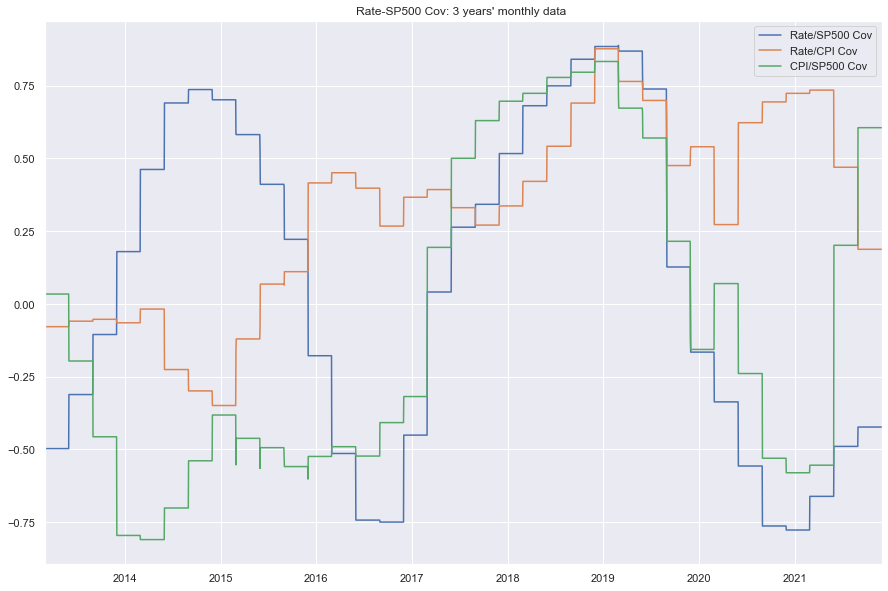

In [10]:
ln1=cov_rate_sp500.plot(label='Rate/SP500 Cov')
ln2=cov_rate_cpi.plot(label='Rate/CPI Cov')
ln3=cov_cpi_sp500.plot(label='CPI/SP500 Cov')
plt.legend()
plt.title("Rate-SP500 Cov: 3 years' monthly data ")